In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import matplotlib.dates
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit
pd.set_option('max_rows', 6)  # max number of rows to show in this notebook — to save space!
import shapely


/Users/kthyng/miniconda3/envs/cart/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

plots = {'Water Level [m]': {'color': '0.1', 'marker': 'o', 's': 200, 'alpha': 1, 'linewidths': 2}, 
         'Gage height [m]': {'marker': 'o', 's': 200, 'alpha': 1}, 
         'East [m/s]': {'color': 'w', 'marker': 'v', 's': 120, 'alpha': 1},
         'Salinity': {'color': 'w', 'marker': '*', 's': 280, 'alpha': 1}, 
         'Along [cm/s]': {'color': 'w', 'marker': '^', 's': 150, 'alpha': 1},
         'Rain [cm]': {'marker': 's', 's':200, 'alpha': 1},
         'Flow rate [m^3/s]': {'marker': '>', 's': 200, 'alpha': 1}}

b = 'drive_data/'
baseb = b + 'bathy/'
basesf = b + 'shapefiles/'
based = b + 'stations/'

In [ ]:
d = np.load(baseb + 'bathy_galv_clean.npz')  # all of Galveston Bay
bathy = d['bathy']; dx = d['dx']; dy = d['dy']; lon = d['lon']; lat = d['lat']
bathyo = np.load(baseb + 'bathy_every_fifth.npz')['bathy'][::-1,:][1:-1,1:-1]  # all
bathyo = np.ma.masked_where(bathyo>0, bathyo)


In [3]:
run buoy_info.py

In [4]:
# See make_data notebook. This reads in data from many sources, recalculates so that all data is hourly by taking 
# hourly averages, and shifts water levels to all be mean high water to match the bathymetry.
df = pd.read_csv(based + 'data06to03-15min.csv', parse_dates=True, index_col=0)

dstart = '2017-06-01'; dend = '2017-12-31'

df['8770613: Salinity']['2017-9-20 09:00'] = np.nan  # bad data point

In [5]:
saltcols = [col for col in df.columns if 'Salinity' in col]
saltcols = [col for col in saltcols if not 'OLDR' in col]
saltcols = [col for col in saltcols if not 'B:' in col]
saltcols

['FISH: Salinity',
 'MIDG: Salinity',
 'TRIN: Salinity',
 'BOLI: Salinity',
 '8770613: Salinity',
 '8771013: Salinity']

In [6]:

for col in saltcols:
    df[col + ' (log)'] = np.log(df[col])
    
# get some datetime numbers to use in calculation
df['idx'] = date2num(df.index.to_pydatetime())


# Quigg CTD data

In [7]:
dfq = pd.read_csv('../quigg/HurricanSamplingDepthProfiles.csv', header=1, na_values=' -')
dfq.drop(dfq[dfq.isnull().sum(axis=1) == 14].index, inplace=True)  # drop blank lines
dfq[['Date', 'Time','Trip Type', 'Station', 'Lat', 'Long']] = dfq[['Date', 'Time','Trip Type', 'Station', 'Lat', 'Long']].ffill(axis=0)
dfq.drop_duplicates(inplace=True)
dfq.index = pd.to_datetime(dfq['Date'] + ' ' + dfq['Time'])
dfq.drop(['Date', 'Time'], axis=1, inplace=True)
# convert to UTC
dfq = dfq.tz_localize('US/Central').tz_convert('UTC')

# get some datetime numbers to use in calculation
dfq['idx'] = date2num(dfq.index.to_pydatetime())
# fix type
dfq = dfq.astype({'Lat': 'float', 'Long': 'float','Wave Ht (ft)': 'float', 'Depth (m)' : 'int',
       'Temp (°C)' : 'float', 'Salinity (psu)' : 'float', 'LDO (mg/L)' : 'float', 'LDO %' : 'float', 'pH' : 'float',
       'SpC (mS/cm)' : 'float'})
dfq['2017-9-9'][:6]

,Trip Type,Station,Lat,Long,Wave Ht (ft),Depth (m),Temp (°C),Salinity (psu),LDO (mg/L),LDO %,pH,SpC (mS/cm),idx
2017-09-09 14:09:00+00:00,R/V Trident,H1,29.670556,-94.978889,0.0,0,25.93,4.35,5.24,67.4,7.42,7.787,736581.589583
2017-09-09 14:09:00+00:00,R/V Trident,H1,29.670556,-94.978889,NaN,1,25.96,4.65,5.27,67.9,7.44,8.239,736581.589583
2017-09-09 14:09:00+00:00,R/V Trident,H1,29.670556,-94.978889,NaN,2,25.98,4.63,5.19,67.4,7.44,8.265,736581.589583
2017-09-09 14:09:00+00:00,R/V Trident,H1,29.670556,-94.978889,NaN,3,25.99,4.67,4.81,62.5,7.45,8.312,736581.589583
2017-09-09 14:39:00+00:00,R/V Trident,H2,29.635833,-94.965833,0.0,0,26.03,5.65,5.40,71.2,7.50,9.990,736581.610417
2017-09-09 14:39:00+00:00,R/V Trident,H2,29.635833,-94.965833,NaN,1,26.08,5.67,5.38,70.5,7.50,10.000,736581.610417


# Introduction to salinity reintroduction timescales

The goal in this work is to provide context for the biological and chemical measurements that were made in the weeks after Hurricane Harvey in Galveston Bay. The samples showed a change from marine to non-marine organisms and a return to marine that varied in time and space in the Bay. Giving spatial information about the timescale of return to marine conditions in the bay will help with interpretation of the changes in population seen.

So, I want to give a spatially-varying timescale for the reintroduction of salinity to Galveston Bay after it has been completely freshened by floodwaters. 


## Theoretical model

For each salinity station, we assume locally input source water at a constant salinity, $S_\infty$ that is instantaneously locally mixed. The flow rate of water, $Q$, into and out of the local, unbounded region of constant volume $V$ is equal and constant, and the resultant salinity which changes in time is $S(t)$ (see image). $S_\infty$ is different for each station.

<img src="figures/model.jpg" alt="Drawing" style="width: 400px;"/>

Using the fact that the salinity introduction timescale, $\tau_s$, has the following relationship: $\tau_s = \frac{V}{Q}$, the following is conservation of salinity in this region:

$
\begin{align}
    \frac{d(SV)}{dt} &= QS_\infty - QS \\
    \frac{dS}{dt} &= \frac{1}{\tau_s}(S_\infty - S) \\
    \Rightarrow S(t) &= S_\infty (1-e^{-t/\tau_s}) ~~~~~~(1)
\end{align}
$


## Linear fit to logscale

I first solved Equation 1 for $\tau_s$ to get:

$
\begin{align}
    \tau_s &= -\frac{1}{\ln|1-S/S_\infty|} t
\end{align}
$

then fit a straight line to the function in log space. The results were not very robust since the salinity is close to zero after the flooding, which makes $\tau_s$ blow up in this form. Perhaps I could transform the equation, run the fit, and transform it back to avoid this problem. Instead I switched to fit the exponential directly (next section).


## Exponential fit

I used non-linear least squares to fit Equation 1 to solve for $\tau_s$ and $S_\infty$ (I needed to include limiting bounds on the parameters to keep them in a reasonal range of values).
   
In the plot, the vertical gray line is what I am counting as the start of when salinity could be reintroduced (or the end of the flooding).

In [8]:
times = {'TRIN': {'fresh': '2017-8-30 00:00', 'start': '2017-9-22 00:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['TRIN: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                 'dx': 0},
         'FISH': {'fresh': '2017-8-30 00:00', 'start': '2017-9-12 00:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['FISH: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                 'dx': 0},                  
         '8770613': {'fresh': '2017-8-29 00:00', 'start': '2017-9-5 00:00', 'stop': '2017-10-11 00:00',
                    'depths': [np.round(1.58496)], 'dx': -0.04},
         'MIDG': {'fresh': '2017-8-29 00:00', 'start': '2017-9-2 00:00', 'stop': '2017-10-11 00:00',
                 'depths': [np.round(df['MIDG: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())], 'dx': -0.04},                  
         '8771013': {'fresh': '2017-8-29 12:00', 'start': '2017-9-12 00:00', 'stop': '2017-10-11 00:00',
                    'depths': [1.28016], 'dx': 0},
         'BOLI': {'fresh': '2017-8-30 00:00', 'start': '2017-9-4 00:00', 'stop': '2017-10-11 00:00', 
                  'depths': [np.round(df['BOLI: Depth [m]']['2017-9-2 00:00':'2017-10-1 00:00'].mean())],
                  'dx': -0.04},
         'H1': {'fresh': '2017-8-30 00:00', 'start':'2017-9-4 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H2': {'fresh': '2017-8-30 00:00', 'start':'2017-9-4 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H3': {'fresh': '2017-8-30 00:00', 'start':'2017-9-3 12:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H4': {'fresh': '2017-8-30 00:00', 'start':'2017-9-3 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H5': {'fresh': '2017-8-30 00:00', 'start':'2017-9-3 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H6': {'fresh': '2017-8-30 00:00', 'start':'2017-9-4 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H7': {'fresh': '2017-8-30 00:00', 'start':'2017-9-4 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H8': {'fresh': '2017-8-30 00:00', 'start':'2017-9-4 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H9': {'fresh': '2017-8-30 00:00', 'start':'2017-9-2 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04},
         'H10': {'fresh': '2017-8-30 00:00', 'start':'2017-9-2 00:00', 'stop': '2017-9-29 00:00', 'dx': -0.04}}

def recovery(t, Sinf, tau):
    '''exponential function.'''

    return Sinf*(1-np.exp(-t/tau))

In [9]:
def draw_map(fig, axbox, lon, lat, marker):

    axmap = fig.add_axes(axbox, projection=merc)
    axmap.set_frame_on(False) # kind of like it without the box
    axmap.set_extent([-95.1, -94.5, 29.3, 29.8], pc)
    axmap.add_feature(land_10m, facecolor='0.8')
    axmap.set_facecolor('0.8')
    
    axmap.plot(lon, lat, color='r', marker=marker, transform=pc)


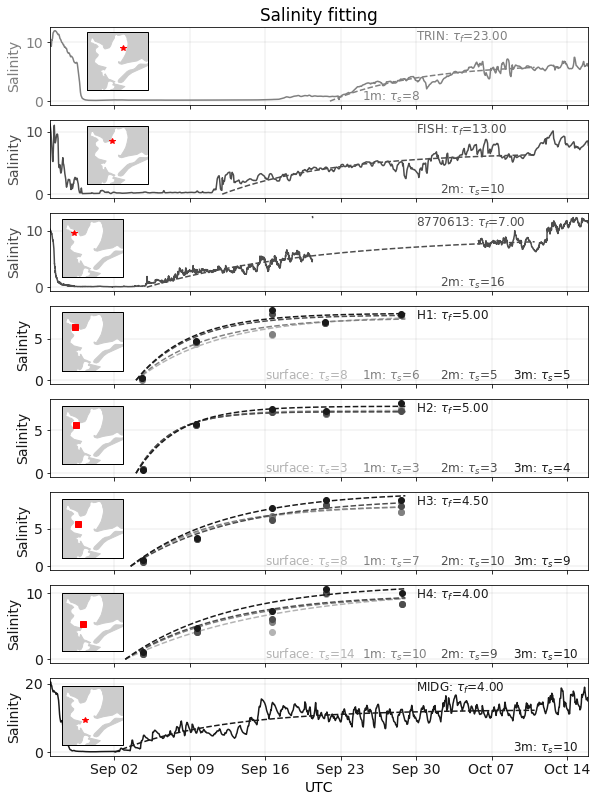

In [25]:
cols = ['TRIN: Salinity', 'FISH: Salinity', '8770613: Salinity', 'H1', 'H2', 'H3', 'H4', 'MIDG: Salinity']
colorsdict = {'0': '0.7', '1': '0.5', '2': '0.3', '3': '0.1'}
xdict = {'0': 0.40, '1': 0.58, '2': 0.725, '3': 0.86}
textdict = {'0': 'surface', '1': '1m', '2': '2m', '3': '3m'}
ncols = 16

dst = '2017-8-27'; den = '2017-10-15'
fig, axes = plt.subplots(len(cols), 1, figsize=(8.5,11), sharex=True)
fig.subplots_adjust(top=0.97, bottom=0.05, left=0.09, right=0.97)
taus = np.zeros((5, ncols))
tauf = np.zeros(ncols)
tau = []; Sinf = []; #tauf = []
for j, (col, ax) in enumerate(zip(cols, axes)):

    if len(col) <= 3:  # Quigg data
        name = col
        col = 'Salinity (psu)'
        start = times[name]['start']
        stop = times[name]['stop']
        d1 = start; d2 = stop
        fresh = times[name]['fresh']
        depths = dfq[(dfq['Station'] == name)]['Depth (m)'].unique()
        # get a list of df's to have each depth
        dftemps = [dfq[(dfq['Station'] == name) & (dfq['Depth (m)'] == depth)] for depth in depths]
        tnumss = [dftemp['idx'][d1:d2] - dftemp['idx'][0] for dftemp in dftemps]
        lon, lat = dfq[(dfq['Station'] == name)][['Long', 'Lat']].values[0,:]
        marker = 's'
    else:  # station data
        name = col.split(':')[0]
        start = times[name]['start']
        stop = times[name]['stop']
        d1 = start; d2 = stop
        fresh = times[name]['fresh']
        dftemps = [df]
        tnumss = [df['idx'][d1:d2] - df['idx'][d1]]
        depths = times[name]['depths']
        lon, lat = buoys[name]['ll']
        marker = '*'
    dx = times[name]['dx']
        
    for i, (dftemp, depth, tnums) in enumerate(zip(dftemps, depths, tnumss)):
        if i == 4:  # skip depth =4 which has fewer data points
            continue
        color = colorsdict[str(int(depth))]
        xtext = xdict[str(int(depth))]
        textstart = textdict[str(int(depth))]
        # get fit
        inds = ~dftemp[col][d1:d2].isnull()
        fit = curve_fit(recovery, tnums[inds], dftemp[col][d1:d2][inds], bounds=(0,90))
        # use tnums from time series data to have more coordinates
        data_fit = recovery(df['idx'][d1:d2] - df['idx'][d1], *fit[0])
        Sinf.append(fit[0][0])

        # linear
        ax.plot(data_fit.index, data_fit, '--', color=color)  # plot fit
        if len(name) <= 3:  # Quigg data
            taus[i,j] = fit[0][1]
        
            ax.plot(dftemp[col][dst:den], 'o', color=color)
            text = textstart + r': $\tau_s$=%1.0f, ' % np.round(taus[i,j])
            ax.text(xtext, 0.05, text[:-2], transform=ax.transAxes, color=color, fontsize=12)
        else:
            taus[:,j] = fit[0][1]
            ax.plot(dftemp[col][dst:den], color=color)
            text = textstart + r': $\tau_s$=%1.0f, ' % (np.round(taus[0,j]))
            ax.text(xtext, 0.05, text[:-2], transform=ax.transAxes, color=color, fontsize=12)

    
    
    # how long fresh
    tauf[j] = (pd.Timestamp(d1) - pd.Timestamp(fresh)).total_seconds()/86400

    # write station name and tauf
    ax.text(0.68, 0.82, name + r': $\tau_f$=%1.2f' % (tauf[j]), 
            transform=ax.transAxes, color=color, fontsize=12)

    ax.tick_params(labelcolor=color)
    ax.set_ylabel('Salinity', color=color)

    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)

    # add map
    draw_map(fig, [0.15+dx, 0.877 - j*0.118, 0.1, 0.1], lon, lat, marker)

days = mpl.dates.DayLocator(interval=7)
ax.xaxis.set_major_locator(days)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))

axes[0].set_title('Salinity fitting')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)

fig.savefig('figures/salinity_reintroduction1.png')


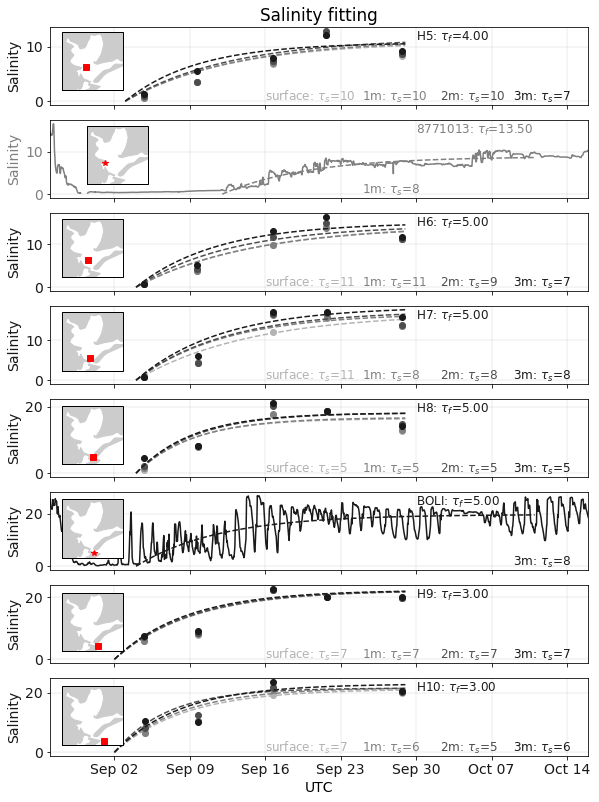

In [26]:
cols = ['H5', '8771013: Salinity', 'H6', 'H7', 'H8', 'BOLI: Salinity', 'H9', 'H10']
colorsdict = {'0': '0.7', '1': '0.5', '2': '0.3', '3': '0.1'}
xdict = {'0': 0.40, '1': 0.58, '2': 0.725, '3': 0.86}
textdict = {'0': 'surface', '1': '1m', '2': '2m', '3': '3m'}

dst = '2017-8-27'; den = '2017-10-15'
fig, axes = plt.subplots(len(cols), 1, figsize=(8.5,11), sharex=True)
fig.subplots_adjust(top=0.97, bottom=0.05, left=0.09, right=0.97)
tau = []; Sinf = []; #tauf = []
for j, (col, ax) in enumerate(zip(cols, axes)):

    if len(col) <= 3:  # Quigg data
        name = col
        col = 'Salinity (psu)'
        start = times[name]['start']
        stop = times[name]['stop']
        d1 = start; d2 = stop
        fresh = times[name]['fresh']
        depths = dfq[(dfq['Station'] == name)]['Depth (m)'].unique()
        # get a list of df's to have each depth
        dftemps = [dfq[(dfq['Station'] == name) & (dfq['Depth (m)'] == depth)] for depth in depths]
        tnumss = [dftemp['idx'][d1:d2] - dftemp['idx'][0] for dftemp in dftemps]
        lon, lat = dfq[(dfq['Station'] == name)][['Long', 'Lat']].values[0,:]
        marker = 's'
    else:  # station data
        name = col.split(':')[0]
        start = times[name]['start']
        stop = times[name]['stop']
        d1 = start; d2 = stop
        fresh = times[name]['fresh']
        dftemps = [df]
        tnumss = [df['idx'][d1:d2] - df['idx'][d1]]
        depths = times[name]['depths']
        lon, lat = buoys[name]['ll']
        marker = '*'
    dx = times[name]['dx']
        
    for i, (dftemp, depth, tnums) in enumerate(zip(dftemps, depths, tnumss)):
        if i == 4:  # skip depth =4 which has fewer data points
            continue
        color = colorsdict[str(int(depth))]
        xtext = xdict[str(int(depth))]
        textstart = textdict[str(int(depth))]
        # get fit
        inds = ~dftemp[col][d1:d2].isnull()
        fit = curve_fit(recovery, tnums[inds], dftemp[col][d1:d2][inds], bounds=(0,90))
        # use tnums from time series data to have more coordinates
        data_fit = recovery(df['idx'][d1:d2] - df['idx'][d1], *fit[0])
        Sinf.append(fit[0][0])

        # linear
        ax.plot(data_fit.index, data_fit, '--', color=color)  # plot fit
        if len(name) <= 3:  # Quigg data
            taus[i,j+len(cols)] = fit[0][1]
        
            ax.plot(dftemp[col][dst:den], 'o', color=color)
            text = textstart + r': $\tau_s$=%1.0f, ' % np.round(taus[i,j+len(cols)])
            ax.text(xtext, 0.05, text[:-2], transform=ax.transAxes, color=color, fontsize=12)
        else:
            taus[:,j+len(cols)] = fit[0][1]
            ax.plot(dftemp[col][dst:den], color=color)
            text = textstart + r': $\tau_s$=%1.0f, ' % (np.round(taus[0,j+len(cols)]))
            ax.text(xtext, 0.05, text[:-2], transform=ax.transAxes, color=color, fontsize=12)

    
    
    # how long fresh
    tauf[j+len(cols)] = (pd.Timestamp(d1) - pd.Timestamp(fresh)).total_seconds()/86400

    # write station name and tauf
    ax.text(0.68, 0.82, name + r': $\tau_f$=%1.2f' % (tauf[j+len(cols)]), 
            transform=ax.transAxes, color=color, fontsize=12)

    ax.tick_params(labelcolor=color)
    ax.set_ylabel('Salinity', color=color)

    ax.grid(which='major', lw=1.5, color='k', alpha=0.05)
    ax.grid(which='minor', lw=1, color='k', alpha=0.05)

    # add map
    draw_map(fig, [0.15+dx, 0.877 - j*0.118, 0.1, 0.1], lon, lat, marker)

days = mpl.dates.DayLocator(interval=7)
ax.xaxis.set_major_locator(days)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d'))

axes[0].set_title('Salinity fitting')
axes[-1].set_xlabel('UTC')
axes[-1].autoscale(enable=True, axis='x', tight=True)

fig.savefig('figures/salinity_reintroduction2.png')#, bbox_inches='tight')


## Time fresh before salinity reintroduction

In [27]:
cols = ['TRIN', 'FISH', '8770613', 'H1', 'H2', 'H3', 'H4', 'MIDG',
       'H5', '8771013', 'H6', 'H7', 'H8', 'BOLI', 'H9', 'H10']
shift = {'TRIN': (0.01,0.01), 'FISH': (0.01,0.01), '8770613': (-0.03,0.01), 'H1': (0.02,0.0), 
      'H2': (0.01,0.01), 'H3': (0.01,0.01), 'H4': (0.01,0.01), 'MIDG': (0.01,0.01),
      'H5': (0.015,0), '8771013': (-0.03,0.01), 'H6': (0.01,0.01), 'H7': (0.01,0.01), 
      'H8': (0.01,0.01), 'BOLI': (0.0,0.01), 'H9': (0.01,0.01), 'H10': (0.01,0.01)}

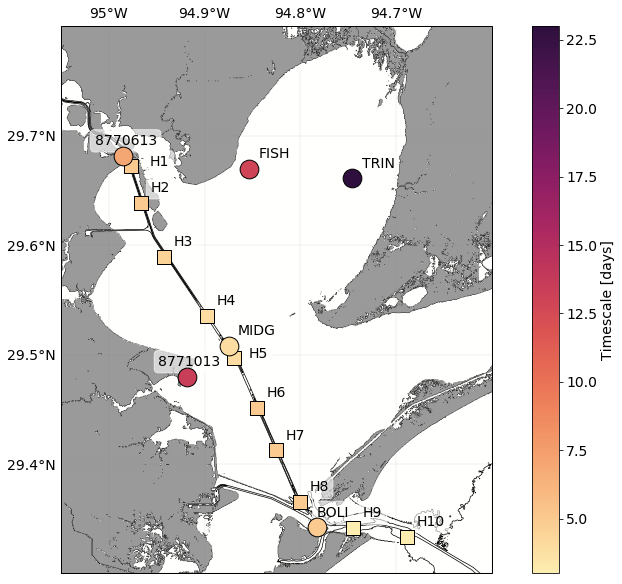

In [67]:

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = (tauf).min(); vmax = (tauf).max()
for saltcol, taf in zip(cols, tauf):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    param = taf
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.matter, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Timescale [days]')

fig.savefig('figures/time_tauf.png', bbox_inches='tight')

* can colorbar have sections so easier to read values?

## Time until 63% recovery

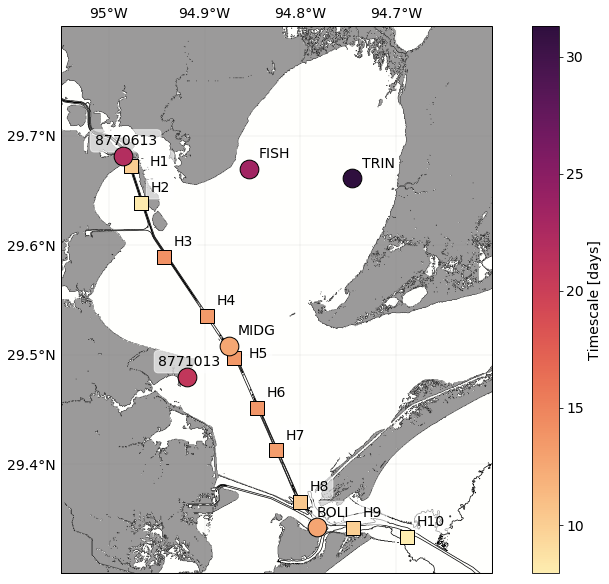

In [139]:

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = (tauf+taus[2,:]).min(); vmax = (tauf+taus[2,:]).max()
for saltcol, taf, ta in zip(cols, tauf, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    start = pd.Timestamp(times[buoy]['start'])
    # count all from same end-of-storm time to be standardized
    dt = pd.Timestamp(start) - pd.Timestamp('2017-8-30 00:00')
    param = dt.total_seconds()/86400 + ta
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.matter, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Timescale [days]')

fig.savefig('figures/time_63recovery_new.png', bbox_inches='tight')

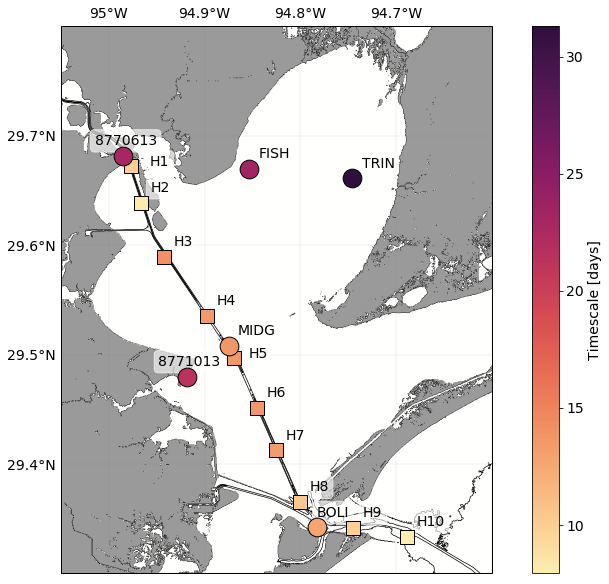

In [33]:

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = (tauf+taus[2,:]).min(); vmax = (tauf+taus[2,:]).max()
for saltcol, taf, ta in zip(cols, tauf, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    param = taf+ta
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.matter, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Timescale [days]')

fig.savefig('figures/time_63recovery.png', bbox_inches='tight')

## Salinity reintroduction timescale

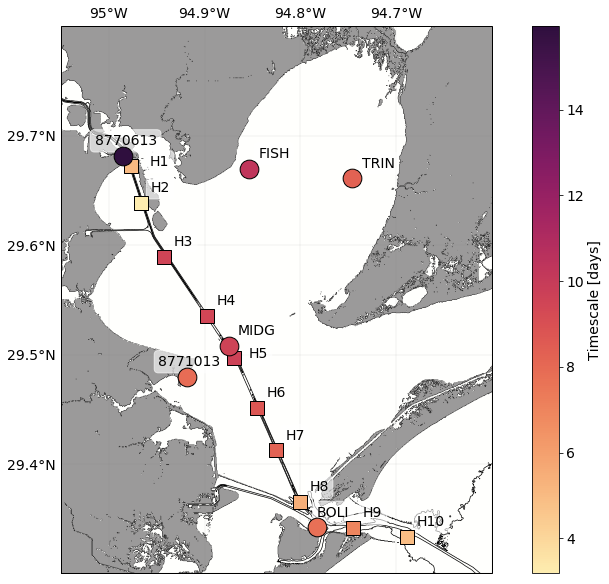

In [34]:

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = (taus[2,:]).min(); vmax = (taus[2,:]).max()
for saltcol, ta in zip(cols, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    param = ta
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.matter, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Timescale [days]')

fig.savefig('figures/time_taus.png', bbox_inches='tight')

## % recovery

$\tau_f + S_\infty (1-e^{-t/\tau_s}) $

### 9/4

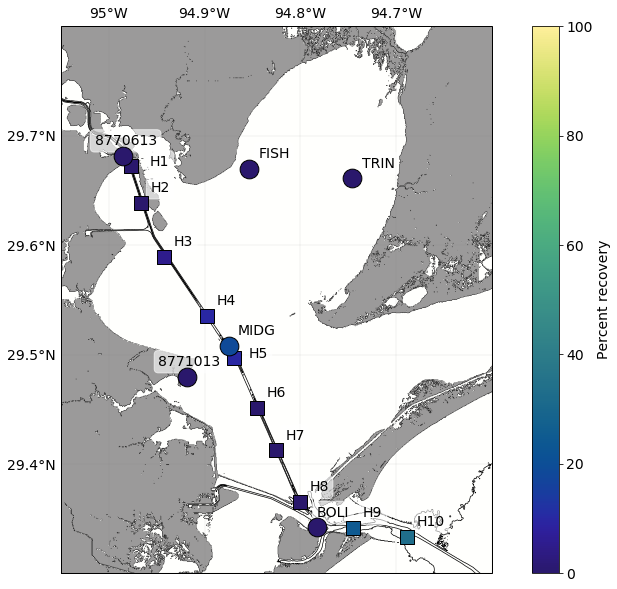

In [114]:
date = pd.Timestamp('2017-9-4 00:00')

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = 0; vmax = 100
for saltcol, ta in zip(cols, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    start = pd.Timestamp(times[buoy]['start'])
    if date < start:
        param = 0
    else:
        tnums = df['idx'][date] - df['idx'][start]
        param = (1 - np.exp(-tnums/ta))*100
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.haline, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Percent recovery')

fig.savefig('figures/time_percent9-4.png', bbox_inches='tight')

### 9/9

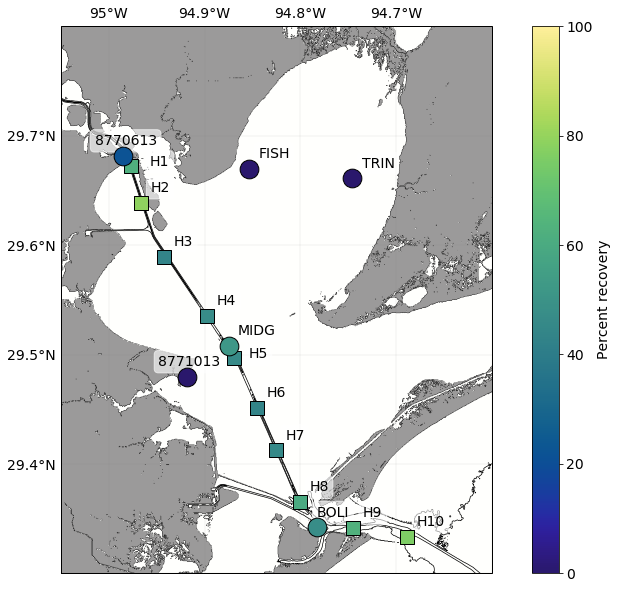

In [115]:
date = pd.Timestamp('2017-9-9 00:00')

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = 0; vmax = 100
for saltcol, ta in zip(cols, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    start = pd.Timestamp(times[buoy]['start'])
    if date < start:
        param = 0
    else:
        tnums = df['idx'][date] - df['idx'][start]
        param = (1 - np.exp(-tnums/ta))*100
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.haline, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Percent recovery')

fig.savefig('figures/time_percent9-9.png', bbox_inches='tight')

### 9/16

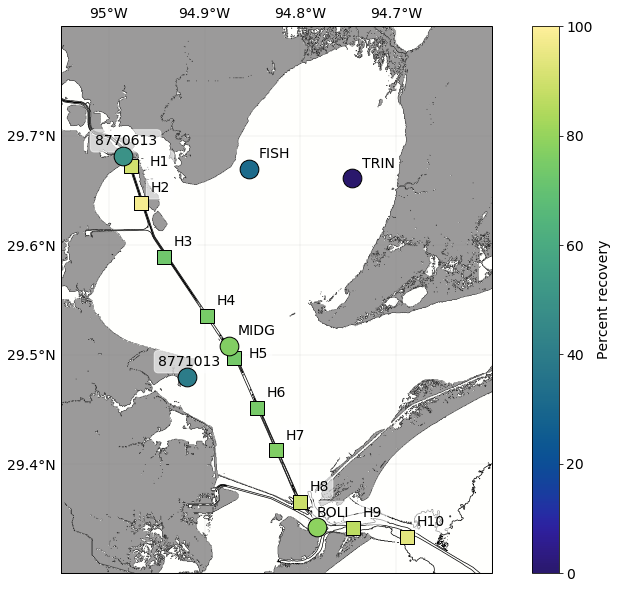

In [116]:
date = pd.Timestamp('2017-9-16 00:00')

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = 0; vmax = 100
for saltcol, ta in zip(cols, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    start = pd.Timestamp(times[buoy]['start'])
    if date < start:
        param = 0
    else:
        tnums = df['idx'][date] - df['idx'][start]
        param = (1 - np.exp(-tnums/ta))*100
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.haline, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Percent recovery')

fig.savefig('figures/time_percent9-16.png', bbox_inches='tight')

### 9/21

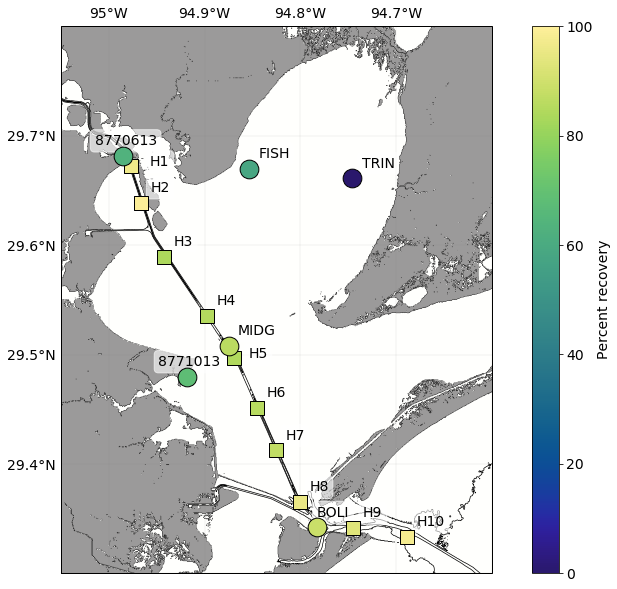

In [117]:
date = pd.Timestamp('2017-9-21 00:00')

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = 0; vmax = 100
for saltcol, ta in zip(cols, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    start = pd.Timestamp(times[buoy]['start'])
    if date < start:
        param = 0
    else:
        tnums = df['idx'][date] - df['idx'][start]
        param = (1 - np.exp(-tnums/ta))*100
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.haline, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Percent recovery')

fig.savefig('figures/time_percent9-21.png', bbox_inches='tight')

### 9/28

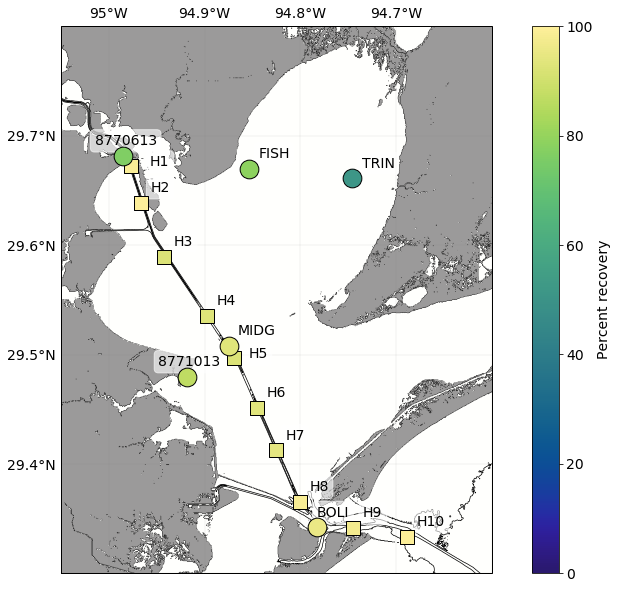

In [118]:
date = pd.Timestamp('2017-9-28 00:00')

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = 0; vmax = 100
for saltcol, ta in zip(cols, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    start = pd.Timestamp(times[buoy]['start'])
    if date < start:
        param = 0
    else:
        tnums = df['idx'][date] - df['idx'][start]
        param = (1 - np.exp(-tnums/ta))*100
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.haline, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Percent recovery')

fig.savefig('figures/time_percent9-28.png', bbox_inches='tight')

### 11/4

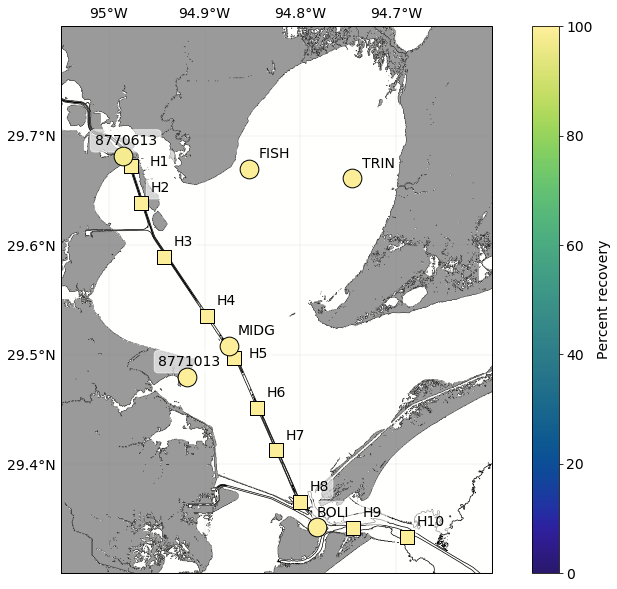

In [119]:
date = pd.Timestamp('2017-11/4 00:00')

fig = plt.figure(figsize=(12, 8))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent([-95.05, -94.6, 29.3, 29.8], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.1))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.1))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry contours
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-')  # some values

# add bay-area detailed coastline
ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# color land
ax.pcolormesh(lon, lat, bathyo.mask, cmap=cmo.gray_r, vmin=0, vmax=3, transform=pc)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.6)

# plot buoys
vmin = 0; vmax = 100
for saltcol, ta in zip(cols, taus[2,:]):
    buoy = saltcol
    dx, dy = shift[buoy]
    if len(buoy) <= 3:
        lonsta, latsta = dfq[(dfq['Station'] == buoy)][['Long', 'Lat']].values[0,:]
        marker = 's'
        zorder = 8
        s = 200
    else:
        lonsta, latsta = buoys[buoy]['ll']
        marker = 'o'
        zorder = 10
        s = 350
    start = pd.Timestamp(times[buoy]['start'])
    if date < start:
        param = 0
    else:
        tnums = df['idx'][date] - df['idx'][start]
        param = (1 - np.exp(-tnums/ta))*100
    mappable = ax.scatter(lonsta, latsta, c=param, s=s, transform=pc, zorder=zorder, 
                          vmin=vmin, vmax=vmax, cmap=cmo.haline, edgecolors='k', marker=marker)
    ax.text(lonsta+dx, latsta+dy, buoy, transform=pc, bbox=props)
cb = plt.colorbar(mappable)
cb.set_label('Percent recovery')

fig.savefig('figures/time_percent11-4.png', bbox_inches='tight')

### Two timescales

There are two important time scales here:

1. time before salinity reintroduction
1. timescale of salinity reintroduction

The overall timescale should be a combination of the two, something like:

$ \tau = \tau_{f} + P*\tau_{s} $,

where $\tau_s$ is the timescale in the exponential describing salinity reintroduction, $\tau_f$ is the timescale describing how long the station stayed fresh, and $P$ is the percent back to "normal" the salinity is, out of 100%. For example, we see the following:

$
\begin{align}
    &S(t) = S_\infty (1-e^{-t/\tau_s}) \\
    &S(0) = 0 \\
    &S(\tau_s) = 63\% S_{\infty} \\
    &S(3\tau_s) = 95\% S_{\infty} \\
    &S(5\tau_s) = 99\% S_{\infty}
\end{align}
$

So, a station is back to 63% salinity after time $t=\tau_s$, giving an overall timescale $\tau$ of:

$\tau = \tau_{f} + \tau_{s}$.

A station is back to 95% salinity after time $t=3*\tau_s$, giving an overall timescale of

$\tau = \tau_{f} + 3\tau_{s}$.


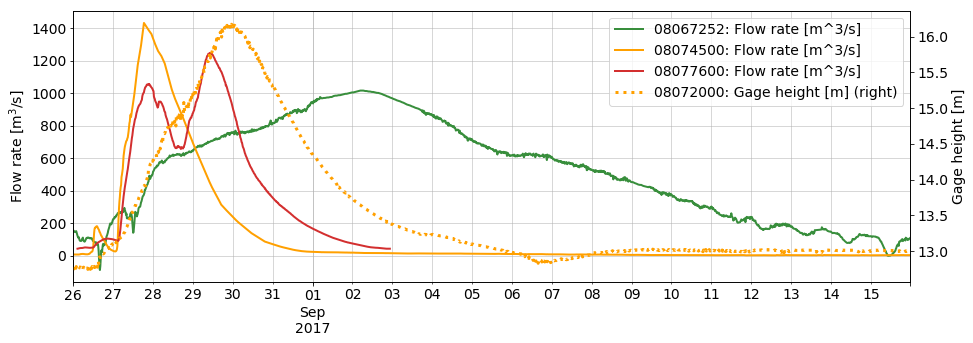

In [135]:
# df['08068090: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(legend=True)
# df['08076000: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(legend=True)
ax = df['08067252: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(figsize=(10,3), legend=True, color=buoys['08067252']['color'],lw=2)
df['08074500: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(ax=ax, legend=True, color=buoys['08074500']['color'],lw=2)
df['08077600: Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(ax=ax, legend=True, color=buoys['08077600']['color'],lw=2)
axt = df['08072000: Gage height [m]']['2017-8-26':'2017-9-15'].plot(figsize=(15,5), legend=True, secondary_y=True, ax=ax, 
                                                                    color=buoys['08072000']['color'], lw=3, ls=':')

ax.grid(True, which='both', linewidth=1, alpha=0.5)
ax.set_ylabel('Flow rate [m$^3$/s]')
axt.set_ylabel('Gage height [m]')
# plt.legend(['08068090', '08067252','08066500'])
plt.savefig('figures/flow_rate.pdf', bbox_inches='tight')

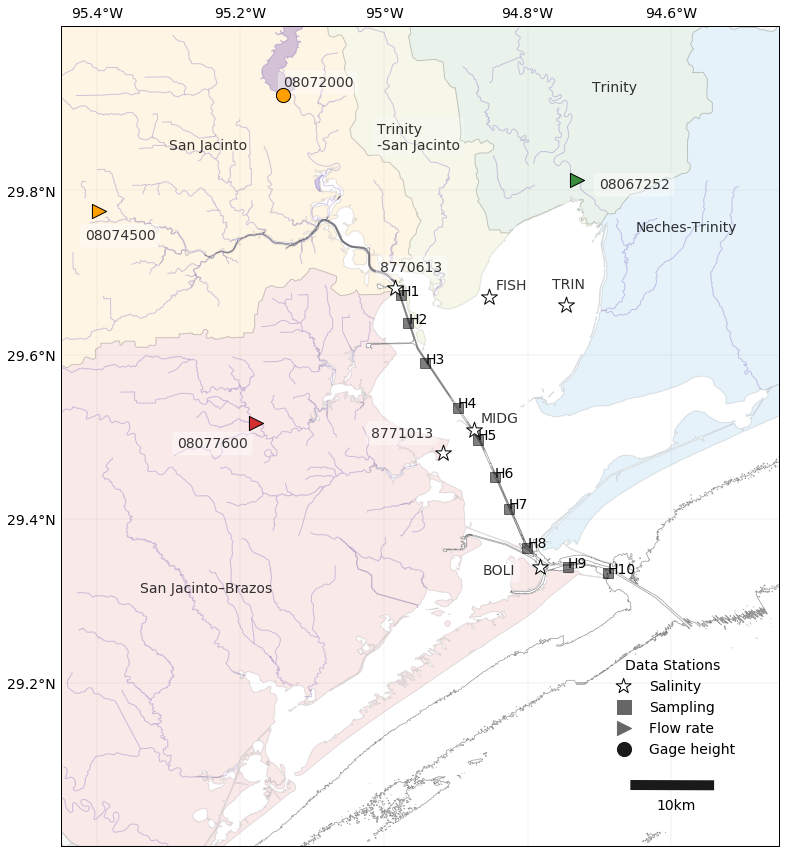

In [112]:

extent = [-95.45, -94.45, 29, 30.0]
x1, x2, y1, y2 = extent
pts = np.array([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])
ext = shapely.geometry.Polygon(pts)


fig = plt.figure(figsize=(14, 12))# (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) # kind of like it without the box
ax.set_extent(extent, pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mpl.ticker.FixedLocator(np.arange(-96.2, -93.0, 0.2))
gl.ylocator = mpl.ticker.FixedLocator(np.arange(28.6, 31, 0.2))
gl.xlabels_bottom = False  # turn off labels where you don't want them
gl.ylabels_right = False

# bathymetry, but only near bay
# mappable = ax.contourf(lon, lat, bathyo, [-25, -20, -15, -10, -8, -6, -4, -2, 0], vmin=-40, cmap=cmo.gray, transform=pc)
# cb = fig.colorbar(mappable, orientation='horizontal', shrink=0.5, pad=0.025)
# cb.set_label('Depth [m]')

# # add background land
# ax.add_feature(land_10m)

# # add bay-area detailed coastline
# ax.contour(lon, lat, bathyo.mask, 1, colors='0.1', linewidths=0.4, transform=pc)  # coastline

# bathymetry contours to highlight shipping lanes
ax.contour(lon, lat, bathyo, [-20,-15,-10], colors='k', linewidths=0.7, transform=pc, linestyles='-', alpha=0.4)  # some values


# Add river basins to plot
reader = cartopy.io.shapereader.Reader(basesf + 'Major_River_Basins_Shapefile/TWDB_MRBs_2014.shp')
basins = reader.records()
for basin in basins:
    if basin.attributes['basin_name'] == 'San Jacinto-Brazos':
        facecolor = buoys['OLDR']['color']  # 'red'
    elif basin.attributes['basin_name'] == 'San Jacinto':
        facecolor = buoys['TRIN']['color']  # 'orange'
    elif basin.attributes['basin_name'] == 'Trinity-San Jacinto':
        facecolor = buoys['8771013']['color']  # 'yellow'
    elif basin.attributes['basin_name'] == 'Trinity':
        facecolor = buoys['8771341']['color']  # 'green'
    elif basin.attributes['basin_name'] == 'Neches-Trinity':
        facecolor = buoys['8771972']['color']  # 'blue'
    else:
        facecolor = '0.7'
    ax.add_geometries([basin.geometry], pc, facecolor=facecolor, edgecolor='k', linewidth=1, alpha=0.1)

watercolor = buoys['8770808']['color']

# Add lakes to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_POLY_2014.shp')
lakes = reader.records()
for lake in lakes:
    if ext.contains(lake.geometry.centroid) and "Bay" not in lake.attributes['BASIN_NAME'] \
         and "Gulf" not in lake.attributes['BASIN_NAME']:
        ax.add_geometries([lake.geometry], pc, facecolor=watercolor, edgecolor=watercolor, alpha=0.25)

# Add rivers to plot
reader = cartopy.io.shapereader.Reader(basesf + 'tceq_segments_2014_shp/TCEQ_SEGMENT_LINE_2014.shp')
rivers = reader.records()
for river in rivers:
    if ext.contains(river.geometry.centroid):
        ax.add_geometries([river.geometry], pc, facecolor='none', edgecolor=watercolor, alpha=0.25)
        
props = dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.4)
        
## add buoys ##
for buoy in ['08067252','08074500','08077600','08072000','TRIN', 'FISH', 'MIDG', '8771013', '8770613', 'BOLI', ]:
    try:
        lonsh, latsh = buoys[buoy]['llshift']
    except:
        lonsh, latsh = 0.01, 0.01
    if buoy == '08074500':
        lonsh += 0.08
    elif buoy == '08077600':
        lonsh += 0.05
    elif buoy == '8771013':
        lonsh += 0.05
    elif buoy == 'BOLI':
        latsh -= 0.03
    llsh = buoys[buoy]['ll'][0] + lonsh, buoys[buoy]['ll'][1] + latsh
    ax.text(llsh[0], llsh[1], buoy, transform=pc, fontsize=14, color='0.2', bbox=props)
    for var in ['Gage height [m]','Salinity','Rain [cm]', 'Flow rate [m^3/s]']:
        if var in buoys[buoy]['vars']:
            kwargs = plots[var]
            # use buoy color in some cases
            if not 'color' in kwargs:
                color = buoys[buoy]['color']
                ax.scatter(*buoys[buoy]['ll'], **kwargs, facecolors=color, transform=pc, label=var, edgecolors='k', zorder=5)
            else:
                ax.scatter(*buoys[buoy]['ll'], **kwargs, transform=pc, label=var, edgecolors='k', zorder=5)


# plot Quigg stations
for i in range(1,11):
    name = 'H' + str(i)
    lon, lat = dfq[(dfq['Station'] == name)][['Long', 'Lat']].values[0,:]
    ax.plot(lon, lat, transform=pc, marker='s', ms=10, color='k', alpha=0.5)
    ax.text(lon, lat, name, transform=pc)
                
                
# Add labels
ax.text(-95.3, 29.85, 'San Jacinto', transform=pc, alpha=0.8)
ax.text(-95.01, 29.85, 'Trinity\n-San Jacinto', transform=pc, alpha=0.8, bbox=dict(boxstyle='round', facecolor='w', edgecolor='w', alpha=0.2))
ax.text(-95.34, 29.31, 'San Jacinto–Brazos', transform=pc, alpha=0.8)
ax.text(-94.71, 29.92, 'Trinity', transform=pc, alpha=0.8)
ax.text(-94.65, 29.75, 'Neches-Trinity', transform=pc, alpha=0.8);

# Distance key
llon, llat = -94.65, 29.075
eqproj = cartopy.crs.AzimuthalEquidistant(central_longitude=-95, central_latitude=30)
lx, ly = eqproj.transform_point(llon, llat, pc)  # convert to projection
ax.plot([lx, lx+10e3], [ly, ly], lw=10, transform=eqproj, color='0.1')
ax.text(llon+0.03, llat-0.03, '10km', transform=pc)

# Add legend
ax2 = fig.add_axes([0.72, 0.1, 0.13, 0.3], frameon=False)
ax2.scatter([], [], c='none', linewidths=1, s=250, marker='*', edgecolors='k', label='Salinity')
ax2.scatter([], [], c='0.4', s=200, marker='s', label='Sampling')
# ax2.scatter([], [], c='0.4', s=200, marker='s', label='Precipitation')
# ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=150, marker='v', label='Wind')
ax2.scatter([], [], c='0.4', s=200, marker='>', label='Flow rate')
ax2.scatter([], [], c='0.1', s=200, marker='o', label='Gage height')
# ax2.scatter([], [], c='none', edgecolors='k', linewidths=1, s=200, marker='^', label='Velocity', alpha=1)

ax2.legend(scatterpoints=1, frameon=False, title='Data Stations', loc='lower right')
ax2.set_axis_off()

fig.savefig('figures/map_salinity_reintro.png', bbox_inches='tight', dpi=300)
fig.savefig('figures/map_salinity_reintro_lowres.png', bbox_inches='tight')


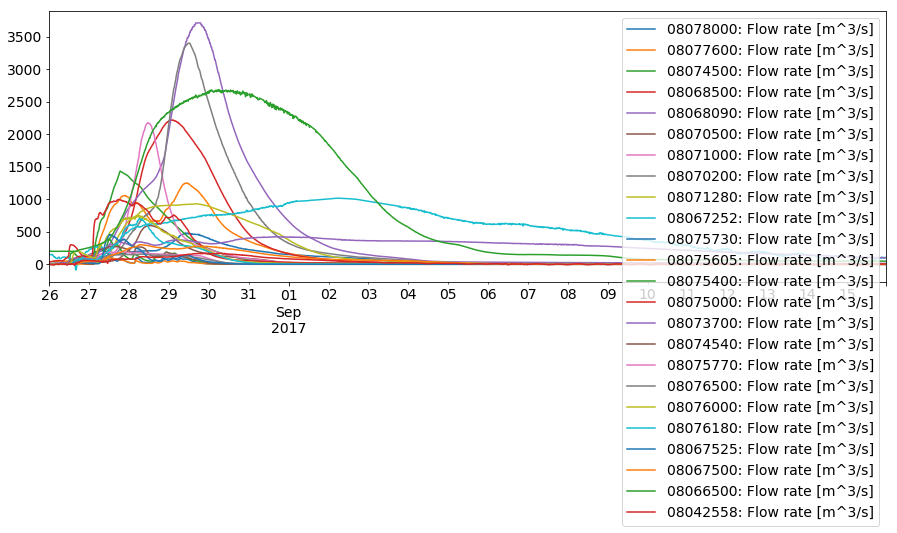

In [44]:
for buoy in buoys.keys():
    for var in buoys[buoy]['vars']:
        if 'Flow' in var:
            df[buoy + ': Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(figsize=(15,5), legend=True)


1545939.2674030284
1046410.3849949145


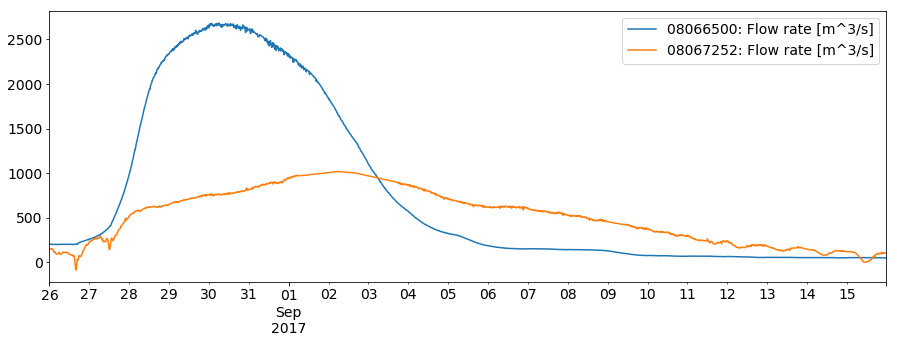

In [144]:
buoys = ['08066500', '08067252']
for buoy in buoys:
    df[buoy + ': Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].plot(figsize=(15,5), legend=True)
    print(df[buoy + ': Flow rate [m^3/s]']['2017-8-26':'2017-9-15'].sum())